# Things To Know

Hey Jason - This contains everything to know here:
- I am using the “baby” dataset from Amazon reviews because it’s a bit more expressive than the digital one. Shouldn’t be a worry though; it just takes a few more minutes to download and I split it into more pieces. 
- There’s a cell with “settings” and “parameters” in the notebook. I’d acquaint yourself with that—those control tunable knobs. 

I’ve run the notebook on smallest settings so far, leading to these extremely good results: FPRs and TPRs when thresholding from np.logspace(-3, 1.2, 22) with 16 chunks are:
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.75, 0.625, 0.25]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.75, 0.625, 0.125, 0.125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

12 vs 16 chunks isn’t a big difference, so I’d just do 12. To do evaluation chunk-wise, I just sample 25 random strings and calculate the test statistic. As it is, the notebook will run in ~20-30 minutes (70M Pythia Model; very small training amounts). Ideally we want to: 1) have more examples in fine-tuning (right now I divide the dataset into 2500 pieces so fine-tuning on 600 or so examples, should probably increase by an order of magnitude), and 2) have bigger models. 

If you e.g. run a 12 chunk model with ~10x the data and 160M model, I’d predict needing around 3-5 hours of Colab runtime. You can save time by keeping things in the GPU as much as possible instead of shuttling a model in and out during fine-tune/evaluation. 



In [ ]:
!pip install datasets
!pip install transformers

In [2]:
import torch
from torch.utils.data import DataLoader, Dataset, random_split
from datasets import load_dataset
from transformers import GPTNeoXForCausalLM, AutoTokenizer
from transformers.optimization import AdamW
from transformers import Trainer, TrainingArguments

## Memory statistics. I had to be careful with cuda memory 
def mem_stats():
    t = torch.cuda.get_device_properties(0).total_memory / 1024**3
    r = torch.cuda.memory_reserved(0) / 1024**3
    a = torch.cuda.memory_allocated(0) / 1024**3
    print(f"Total Memory: {t:.2f} GB\n"
          f"Reserved Memory: {r:.2f} GB ({(100*(r/t)):.2f}%)\n"
          f"Remaining Memory: {t-r:.2f} GB ({(100*(t-r)/t):.2f}%)\n"
          f"---------------------------------\n"
          f"Allocated Memory: {a:.2f} GB ({(100*(a/t)):.2f}%)\n"
          f"Percent of Reserved Allocated: {(100*(a+1e-9)/(r+1e-9)):.2f}%\n")

In [ ]:
from datasets import load_dataset

dataset = load_dataset("amazon_us_reviews", "Baby_v1_00") # Baby reviews a bit more distinctive than CPU

In [38]:
# Settings
small_string_filter = 20 # filters small strings 
dataset_division_constant = 2500 # probably should make 5-10x larger
early_stop_patience = 1 # >= 1 (if val loss increases, runs early_stop_patience more epochs, then stops)

# Parameters
N = 12 # num_models (more doesn't necessarily help that much; I tried 16)
epochs = 12 # epochs to train (unless validation loss rises)
bs = 2
learn = 5e-5
mod_size = "70m"

In [39]:
# Deduping and getting rid of extremely short strings 
global_dataset = dataset["train"]['review_body'][:len(dataset["train"])//dataset_division_constant]
print(f"Dataset Len: {len(global_dataset)}")
global_dataset = list(set(entry for entry in global_dataset))
print(f"Dataset Len: {len(global_dataset)}")
global_dataset = list(set(entry for entry in global_dataset if len(entry) > small_string_filter))
print(f"Dataset Len: {len(global_dataset)}")

Dataset Len: 701
Dataset Len: 689
Dataset Len: 604


In [40]:
validation = dataset["train"]['review_body'][len(dataset["train"])//dataset_division_constant: 2*len(dataset["train"])//dataset_division_constant]
validation = list(set(entry for entry in validation if len(entry) > small_string_filter))

In [41]:
validation = validation[:len(validation) // 2]
print(len(validation))

305


# Data Creation

In [44]:
# Train until train loss = val loss
tokenizer = AutoTokenizer.from_pretrained(f"EleutherAI/pythia-{mod_size}-deduped")

In [45]:
def collate_fn(batch):
    global model
    tokens = [tokenizer.encode(example, return_tensors="pt", truncation=True,max_length=model.config.max_position_embeddings) for example in batch]
    max_length = max([t.size(1) for t in tokens])
    tokens_padded = [torch.cat([t, t.new_zeros(t.size(0), max_length - t.size(1))], dim=1) for t in tokens]
    tokens_padded = torch.cat(tokens_padded, dim=0)
    return {
        "input_ids":tokens_padded,
        "labels":tokens_padded,
        "attention_mask": (tokens_padded > 0).clone().detach().to(dtype=torch.int)
    }

In [46]:
def arr_split(chunks, N):
  if N % 2 != 0:
    print("Need even N!")
    return []
  lists = [[] for i in range(N)]
  
  for i in range(N):
    for j in range(i, int(i + N/2)):
      lists[i] += chunks[j % N]
  
  return lists

In [47]:
def orthogonal_chunk(i):
  return int(N/2 + i) % N

In [48]:
data_chunks = [global_dataset[i * len(global_dataset)//N : (i+1) * len(global_dataset) // N] for i in range(N)]

In [49]:
data_arr = arr_split(data_chunks, N)

In [50]:
len(data_arr[0])

302

# Fine Tune Method

In [51]:
def train(model, train_dataset, val_dataset, collate_fn, batch_size, epochs):
  model = model.to(device)
  model.config.use_cache = False
  training_args = TrainingArguments(output_dir="fine-tuning",
                                    do_train=True,
                                    do_eval=True,
                                    num_train_epochs=epochs,
                                    per_device_train_batch_size=batch_size,
                                    per_device_eval_batch_size=batch_size,
                                    evaluation_strategy="epoch",
                                    logging_strategy="epoch",
                                    save_strategy="epoch",
                                    gradient_accumulation_steps=1,
                                    gradient_checkpointing=False,
                                    load_best_model_at_end = True,
                                    optim="adafactor",
                                    )
  trainer = Trainer(model=model,
                    args=training_args,
                    train_dataset=train_dataset,
                    eval_dataset=val_dataset,
                    tokenizer=tokenizer,
                    data_collator=collate_fn,
                    callbacks=[EarlyStoppingCallback(early_stop_patience, 0.0)] # if val loss improve for >1 iterations, end. 
                  )
  trainer.train()
  return model

# Base Model (to be attacked)

In [52]:
# Fine tune a model on the first 6 chunks of data

from transformers import EarlyStoppingCallback
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
model = GPTNeoXForCausalLM.from_pretrained(f"EleutherAI/pythia-{mod_size}-deduped").to(device)
train(model, data_arr[0], data_arr[orthogonal_chunk(0)], collate_fn, bs, epochs)

cuda


Epoch,Training Loss,Validation Loss
1,19.450600,5.399675
2,3.835500,4.213555
3,2.790000,3.913327
4,2.244000,4.147004


GPTNeoXForCausalLM(
  (gpt_neox): GPTNeoXModel(
    (embed_in): Embedding(50304, 512)
    (layers): ModuleList(
      (0-5): 6 x GPTNeoXLayer(
        (input_layernorm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (post_attention_layernorm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (attention): GPTNeoXAttention(
          (rotary_emb): RotaryEmbedding()
          (query_key_value): Linear(in_features=512, out_features=1536, bias=True)
          (dense): Linear(in_features=512, out_features=512, bias=True)
        )
        (mlp): GPTNeoXMLP(
          (dense_h_to_4h): Linear(in_features=512, out_features=2048, bias=True)
          (dense_4h_to_h): Linear(in_features=2048, out_features=512, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (final_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (embed_out): Linear(in_features=512, out_features=50304, bias=False)
)

# Shadow Models

In [53]:
models = [GPTNeoXForCausalLM.from_pretrained(f"EleutherAI/pythia-{mod_size}-deduped").to(device) for i in range(N)]
mem_stats()

Total Memory: 14.75 GB
Reserved Memory: 8.78 GB (59.53%)
Remaining Memory: 5.97 GB (40.47%)
---------------------------------
Allocated Memory: 8.65 GB (58.66%)
Percent of Reserved Allocated: 98.53%



In [54]:
for i, m in enumerate(models):
  print(f"Model #{i}")
  # m.to(device)
  m = train(m, data_arr[i], data_arr[orthogonal_chunk(i)], collate_fn, bs, epochs)
  # m.to('cpu')
  torch.cuda.empty_cache()

Model #0


Epoch,Training Loss,Validation Loss
1,19.450600,5.399675
2,3.835500,4.213555
3,2.790000,3.913327
4,2.244000,4.147004


Model #1


Epoch,Training Loss,Validation Loss
1,20.095700,5.201274
2,4.070100,4.179569
3,2.845900,4.100634
4,2.235800,4.027329
5,1.626500,4.775106


Model #2


Epoch,Training Loss,Validation Loss
1,19.610800,5.104109
2,3.636100,4.193539
3,2.878600,4.109079
4,2.005600,4.434436


Model #3


Epoch,Training Loss,Validation Loss
1,14.198000,4.495846
2,3.669600,4.226188
3,2.826700,4.114696
4,2.135300,4.391212


Model #4


Epoch,Training Loss,Validation Loss
1,16.751600,4.781190
2,3.456900,3.924072
3,2.738600,4.208817


Model #5


Epoch,Training Loss,Validation Loss
1,16.312900,5.889315
2,3.814500,4.632256
3,2.835700,4.326741
4,2.264300,4.346471


Model #6


Epoch,Training Loss,Validation Loss
1,17.368400,4.879842
2,3.787300,4.366836
3,2.984800,4.518620


Model #7


Epoch,Training Loss,Validation Loss
1,14.952700,6.049477
2,4.415100,5.309657
3,2.812400,4.679349
4,2.158400,4.875332


Model #8


Epoch,Training Loss,Validation Loss
1,15.161200,4.440692
2,3.481100,4.688966


Model #9


Epoch,Training Loss,Validation Loss
1,17.897400,4.638190
2,3.550200,4.106703
3,2.757300,4.244529


Model #10


Epoch,Training Loss,Validation Loss
1,18.245400,4.707933
2,3.770800,4.500659
3,2.676200,3.970432
4,2.104700,4.246475


Model #11


Epoch,Training Loss,Validation Loss
1,18.107400,5.225554
2,3.716300,4.716758
3,2.696900,4.244834
4,2.061300,4.373197


Model #12


Epoch,Training Loss,Validation Loss
1,19.546300,7.928388
2,4.863700,5.565675
3,3.223700,5.860952


Model #13


Epoch,Training Loss,Validation Loss
1,19.048300,6.849393
2,4.592300,5.483454
3,2.901400,5.612309


Model #14


Epoch,Training Loss,Validation Loss
1,14.119800,7.900427
2,4.320900,5.685491
3,3.274800,5.100091
4,2.291600,5.053584
5,1.704800,5.323534


Model #15


Epoch,Training Loss,Validation Loss
1,16.166900,7.863128
2,5.027100,6.522330
3,3.324800,5.456606
4,2.393400,5.414891
5,1.890800,5.886139


In [20]:
# for i, model in enumerate(models):
#   model_save_name = f'model_{i}.pt'
#   path = f"/content/gdrive/My Drive/{model_save_name}" 
#   model.save_pretrained(path)

# Evaluation

In [55]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [56]:
def get_in_models(chunk_no, N):
  """
  Returns a list of models that should be used for inference for a given chunk
  """
  ins = []
  outs = []
  for i in range(N):
    lower = i
    upper = int(i+N/2)
    innit = False
    for j in range(lower, upper):
      if chunk_no == j % N:
        innit = True
    if innit:
      ins.append(i)
    else:
      outs.append(i)
  return (ins, outs)

In [57]:
from torch.nn import CrossEntropyLoss
import math

def compute_ce_loss(model, tokenizer, string):
  input_ids = tokenizer.encode(string, return_tensors="pt").to(device)

  with torch.no_grad():
    outputs = model(input_ids)
    logits = outputs.logits

  loss_fn = CrossEntropyLoss()
  input_len = input_ids.shape[-1] - 1
  input_ids_without_first_token = input_ids[:, 1:]
  logits_without_last_token = logits[:, :-1, :]
  loss = loss_fn(logits_without_last_token.view(-1, logits.size(-1)), input_ids_without_first_token.view(-1))
  return loss

def compute_confidence(ce_loss):
  conf = math.exp(-1 * ce_loss)
  return math.log(conf / (1-conf))

In [58]:
# Generate ROC curve 
import numpy as np
range_of_vals = np.logspace(-3, 1.2, 22)

In [59]:
import random
import scipy.stats as stats

def conf_nums(models, ins, exs, tokenizer):
  confs = []
  for i, m in enumerate(models):
    # m.to(device)
    # print(m, i)
    if i in ins:
      for ex in exs:
        ce_loss = compute_ce_loss(m, tokenizer, ex)
        confs.append(compute_confidence(ce_loss))
    # m.to('cpu')
  return (np.mean(confs), np.std(confs))
    

In [60]:
# We're considering a "chunk" as a discrete entity
tprs = []
fprs = []

for thold in range_of_vals:
  print(f"Threshold: {thold}")
  tp = 0
  fp = 0
  tn = 0
  fn = 0

  for i, chunk in enumerate(data_chunks):
    ins, outs = get_in_models(i, N)
    # Get Random Samples
    exs = random.sample(chunk, 25)

    # Get IN Mu/Stdev
    mu_in, std_in = conf_nums(models, ins, exs, tokenizer)

    # Get OUT Mu/Stdev
    mu_out, std_out = conf_nums(models, outs, exs, tokenizer)

    # Get TARGET Mu
    mu_target, std_target = conf_nums([model], [0], exs, tokenizer)

    likelihood_in = stats.norm.pdf(mu_target, mu_in, std_in)
    likelihood_out = stats.norm.pdf(mu_target, mu_out, std_out)
    lira = likelihood_in / likelihood_out
    above_thresh = lira > thold
    in_true_model = i >= 0 and i < N/2 # this is assuming the first chunk is true
    print(f"{likelihood_in} / {likelihood_out} = {lira} / {above_thresh} / {in_true_model}")

    if in_true_model and above_thresh:
      tp += 1
    elif in_true_model and not above_thresh:
      fn += 1
    elif not in_true_model and above_thresh:
      fp += 1
    else:
      tn += 1

  tprs.append(tp / (tp+fn))
  fprs.append(fp / (fp+tn))

Threshold: 0.001
0.36510673659974124 / 0.03199255684227917 = 11.412239990685622 / True / True
0.3675918282572705 / 0.010598913766109453 = 34.68202840112384 / True / True
0.28327839715597736 / 0.0628681414743866 = 4.50591333722485 / True / True
0.3452075685491406 / 0.038487207175524875 = 8.96941071808058 / True / True
0.26872567403492686 / 0.05118456620600989 = 5.250130927228102 / True / True
0.3681004553139713 / 0.03940734176949732 = 9.340910571108202 / True / True
0.3994164842392889 / 0.017642401354478605 = 22.63957588391986 / True / True
0.4365965567312484 / 0.029493525333223098 = 14.803132273897502 / True / True
0.0435170190130459 / 0.2730575373958058 = 0.1593694113997907 / True / False
0.038620874405213834 / 0.31603469300240083 = 0.12220454038860994 / True / False
0.036535267712361506 / 0.3098854056948909 = 0.1178992848354196 / True / False
0.05762378438367419 / 0.3546205147430992 = 0.16249422125344068 / True / False
0.04060979876303145 / 0.45000958164951804 = 0.09024207576686594 /

In [62]:
print(tprs)
print(fprs)

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.75, 0.625, 0.25]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.75, 0.625, 0.125, 0.125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


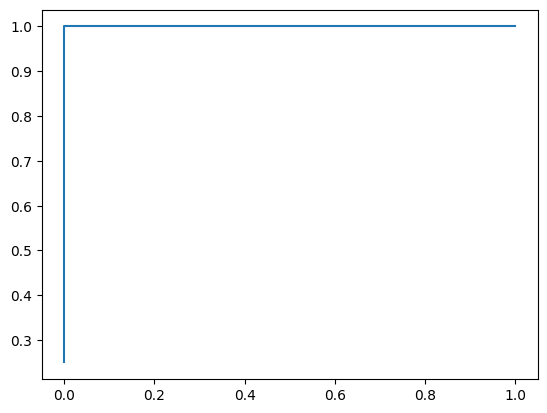

In [64]:
plt.plot(fprs, tprs)
plt.show()